<h1>Segmentation images<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [8]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.9 MB/s eta 0:00:00


## Import

In [10]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from zipfile import ZipFile
from tensorflow import keras
import segmentation_models as sm
import os

Segmentation Models: using `tf.keras` framework.


## Unpack images

In [11]:
from zipfile import ZipFile
  
file_name = "/kaggle/input/carvana-image-masking-challenge/train.zip"

with ZipFile(file_name, 'r') as zipe:
    zipe.printdir()
    print('Extracting all the files now...')
    zipe.extractall()
    print('Done!')

File Name                                             Modified             Size
train/                                         2017-07-20 16:40:16            0
train/00087a6bd4dc_01.jpg                      2017-07-20 16:27:48        95862
train/00087a6bd4dc_02.jpg                      2017-07-20 16:27:48       101777
train/00087a6bd4dc_03.jpg                      2017-07-20 16:27:48       104894
train/00087a6bd4dc_04.jpg                      2017-07-20 16:27:48       105737
train/00087a6bd4dc_05.jpg                      2017-07-20 16:27:48       105479
train/00087a6bd4dc_06.jpg                      2017-07-20 16:27:48       105452
train/00087a6bd4dc_07.jpg                      2017-07-20 16:27:48       105930
train/00087a6bd4dc_08.jpg                      2017-07-20 16:27:48       102312
train/00087a6bd4dc_09.jpg                      2017-07-20 16:27:48        91490
train/00087a6bd4dc_10.jpg                      2017-07-20 16:27:48        99928
train/00087a6bd4dc_11.jpg               

In [12]:
file_name = "/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip"

with ZipFile(file_name, 'r') as zipe:
    zipe.printdir()
    
    print('Extracting all the files now...')
    zipe.extractall()
    print('Done!')

File Name                                             Modified             Size
train_masks.csv                                2017-07-20 16:42:40     45945904
Extracting all the files now...
Done!


In [13]:
!nvidia-smi

Sun Mar 19 14:44:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    32W / 250W |    421MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3487979260962037711
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16105865216
locality {
  bus_id: 1
  links {
  }
}
incarnation: 99977605079104669
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [15]:
def rle_decode(mask_rle, shape = (1280,1918,1)):
    img = np.zeros(shape[0]*shape[1], dtype = np.uint8)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    img = img.reshape(shape)
    return img

In [16]:
def keras_generator(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread('/kaggle/working/train/{}'.format(img_name))
            mask = rle_decode(mask_rle)
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            img = img.astype(np.float32)
            mask = mask.astype(np.float32)
            
            x_batch += [img]
            y_batch += [mask]
            
        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)
        
        yield x_batch, np.expand_dims(y_batch, -1)

## Data frame

In [17]:
df = pd.read_csv('/kaggle/working/train_masks.csv')

In [18]:
df

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...
...,...,...
5083,fff9b3a5373f_12.jpg,386005 13 387915 27 389829 34 391744 38 393660...
5084,fff9b3a5373f_13.jpg,393674 6 395585 19 397498 26 399412 32 401327 ...
5085,fff9b3a5373f_14.jpg,401397 9 403309 19 405223 26 405389 145 407138...
5086,fff9b3a5373f_15.jpg,407257 6 407393 89 409171 12 409263 179 411086...


In [75]:
train_df = df[:4000]
val_df = df[4000:4700]
test_df = df[4700:]

In [20]:
img_name, mask_rle = train_df.iloc[0]

img = cv2.imread('/kaggle/working/train/{}'.format(img_name))
mask = rle_decode(mask_rle)

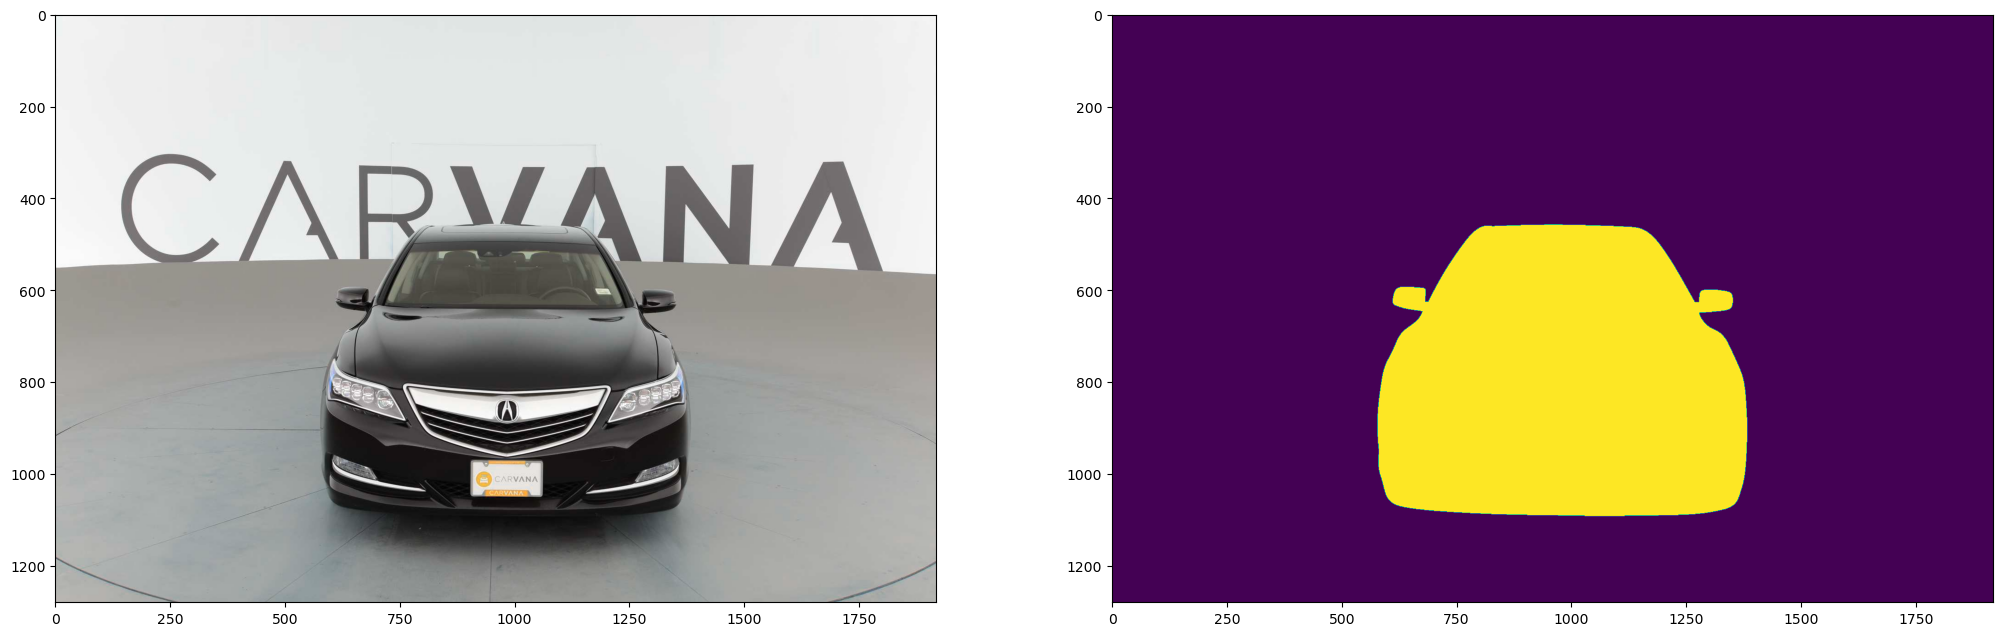

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,25))
axes[0].imshow(img)
axes[1].imshow(mask[...,0])

plt.show()

## Model

In [22]:
n_classes = 1

model = sm.Unet('efficientnetb3', classes=n_classes, activation='sigmoid')

44107200/44107200 [==============================] - 2s 0us/step


In [23]:
best_w = keras.callbacks.ModelCheckpoint('fcn_best.h5',
                                        monitor='val_loss',
                                        verbose=0,
                                        save_best_only=True,
                                        save_weights_only=True,
                                        mode='auto',
                                        period=1)

last_w = keras.callbacks.ModelCheckpoint('fcn_last.h5',
                                        monitor='val_loss',
                                        verbose=0,
                                        save_best_only=False,
                                        save_weights_only=True,
                                        mode='auto',
                                        period=1)

callbacks = [best_w, last_w]

adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=10**-7)

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(adam, total_loss, metrics)

#model.compile(adam, 'binary_crossentropy')

In [26]:
batch_size = 20

history = model.fit(keras_generator(train_df, batch_size),
                   steps_per_epoch = 100,
                   epochs = 5,
                   verbose = 1,
                   callbacks = callbacks,
                   validation_data = keras_generator(val_df, batch_size),
                   validation_steps = 50,
                   class_weight = None,
                   max_queue_size = 10,
                   workers = 1,
                   use_multiprocessing = False,
                   shuffle = True,
                   initial_epoch = 0)

Epoch 1/5
100/100 [==============================] - 106s 1s/step - loss: 0.0136 - iou_score: 0.9845 - f1-score: 0.9922 - val_loss: 0.0147 - val_iou_score: 0.9816 - val_f1-score: 0.9907
Epoch 2/5
100/100 [==============================] - 89s 892ms/step - loss: 0.0128 - iou_score: 0.9852 - f1-score: 0.9925 - val_loss: 0.0146 - val_iou_score: 0.9808 - val_f1-score: 0.9903
Epoch 3/5
100/100 [==============================] - 103s 1s/step - loss: 0.0117 - iou_score: 0.9861 - f1-score: 0.9930 - val_loss: 0.0116 - val_iou_score: 0.9860 - val_f1-score: 0.9930
Epoch 4/5
100/100 [==============================] - 86s 863ms/step - loss: 0.0109 - iou_score: 0.9870 - f1-score: 0.9934 - val_loss: 0.0126 - val_iou_score: 0.9833 - val_f1-score: 0.9916
Epoch 5/5
100/100 [==============================] - 104s 1s/step - loss: 0.0106 - iou_score: 0.9873 - f1-score: 0.9936 - val_loss: 0.0105 - val_iou_score: 0.9868 - val_f1-score: 0.9934


In [27]:
history.history

{'loss': [0.013624784536659718,
  0.012785899452865124,
  0.01174131315201521,
  0.010888161137700081,
  0.010560406371951103],
 'iou_score': [0.9845325350761414,
  0.9851817488670349,
  0.9861229062080383,
  0.9869764447212219,
  0.9873149991035461],
 'f1-score': [0.992205798625946,
  0.9925346970558167,
  0.9930123686790466,
  0.9934455752372742,
  0.9936168193817139],
 'val_loss': [0.014730456285178661,
  0.014591221697628498,
  0.011571531184017658,
  0.012561065144836903,
  0.010534286499023438],
 'val_iou_score': [0.9815962314605713,
  0.9808447360992432,
  0.986029863357544,
  0.983337938785553,
  0.9868447780609131],
 'val_f1-score': [0.9907123446464539,
  0.9903295040130615,
  0.9929655194282532,
  0.9915986657142639,
  0.9933786988258362]}

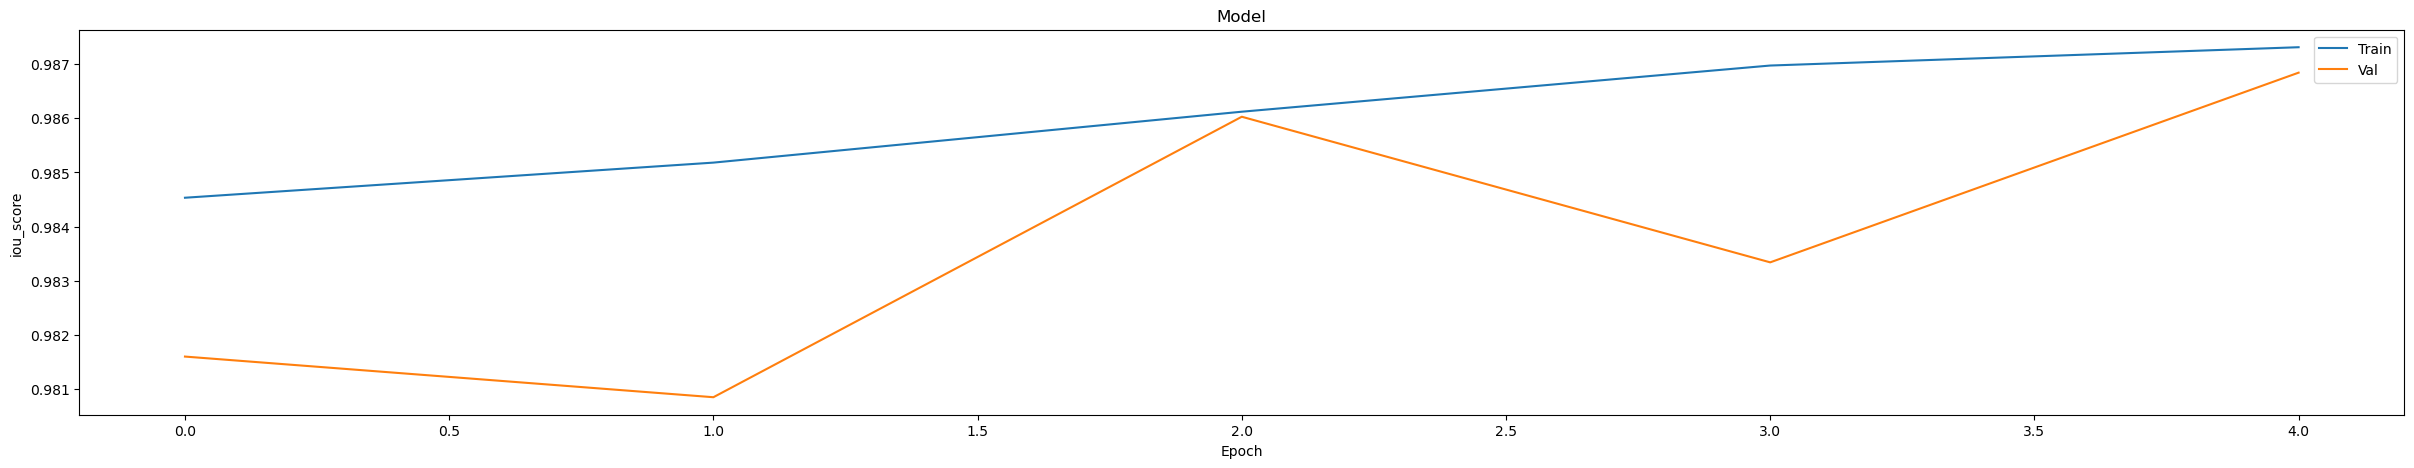

In [28]:
plt.figure(figsize=(30, 5))
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.show()

In [96]:
for x, y in keras_generator(test_df,10):
    break

In [97]:
pred = model.predict(x)

1/1 [==============================] - 0s 38ms/step


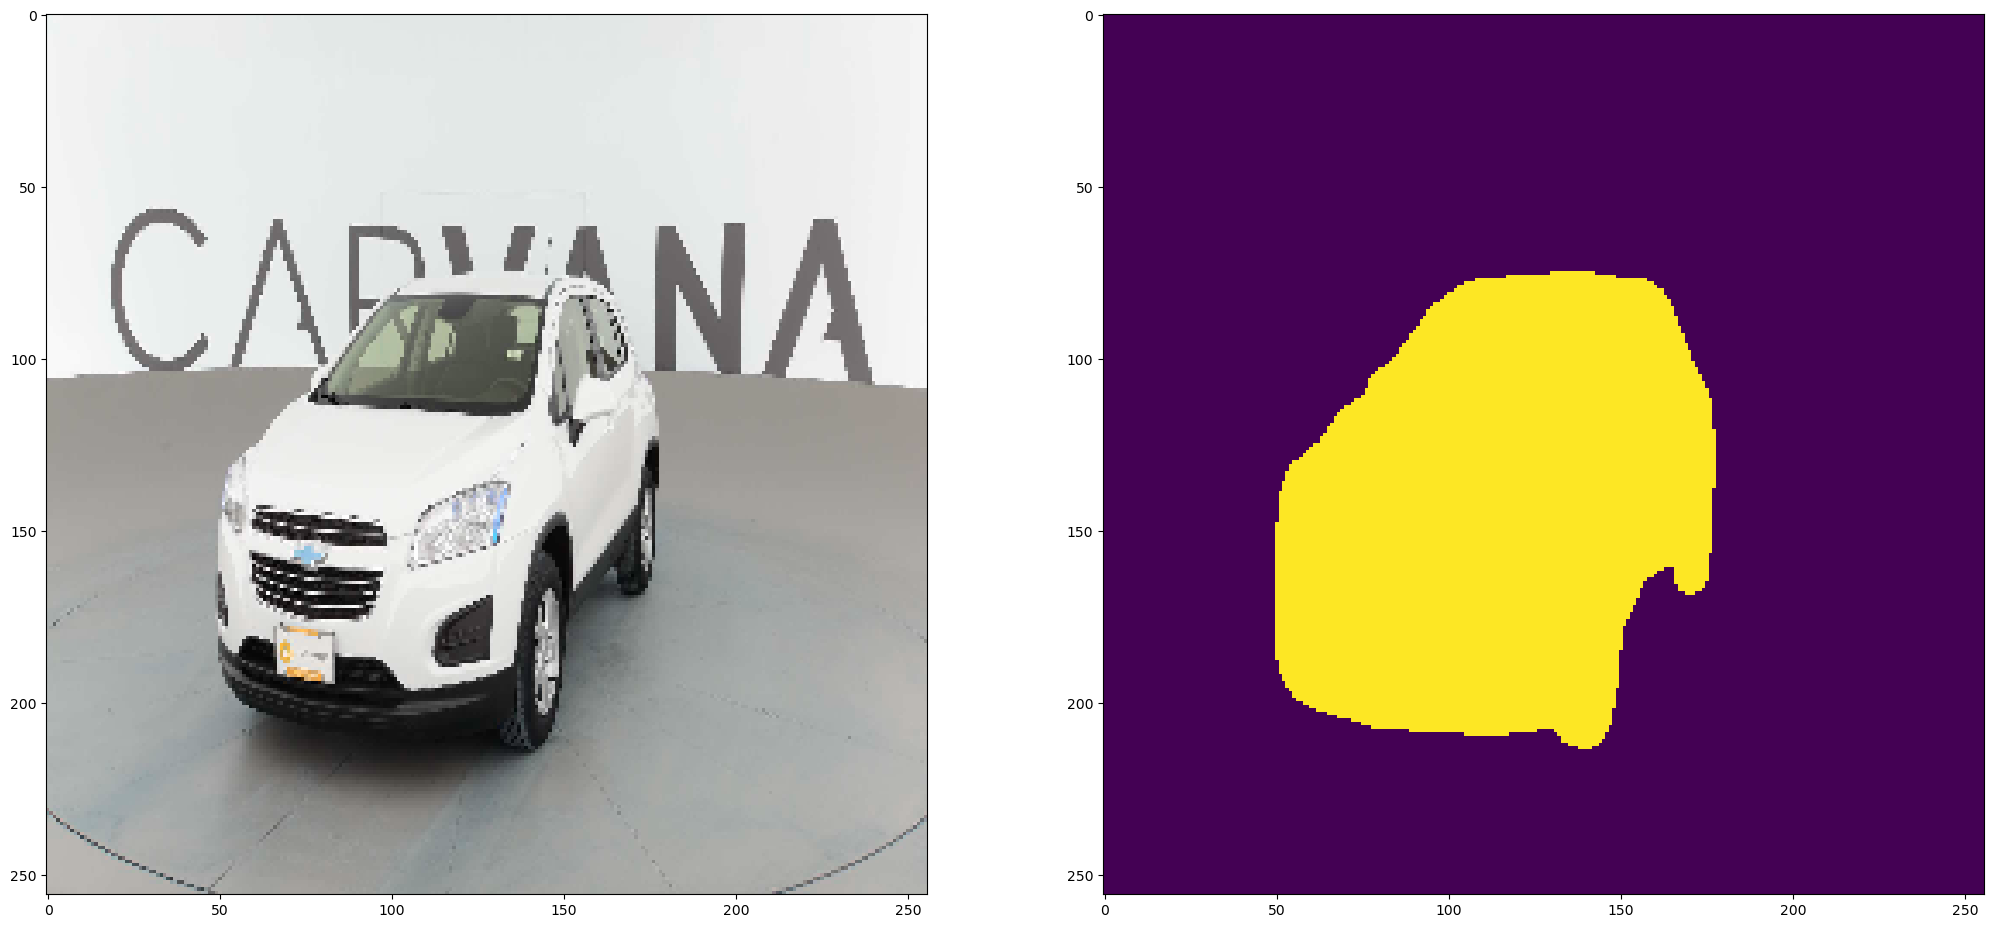

In [98]:
im_id = 6
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id,...,0]>0.5)

plt.show()

## Model Evaluation

In [95]:
sc = []
i=0
while i <200:
    scores = model.evaluate(keras_generator(test_df, batch_size = 1), steps = 1)
    sc.append(scores)
    i+=1
    
q = np.array(sc)

print("Loss: {:.5}".format(q[:,0].mean()))
print("iou_score: {:.5}".format(q[:,1].mean()))
print("f1-score: {:.5}".format(q[:,2].mean()))


1/1 [==============================] - 0s 53ms/step - loss: 0.0131 - iou_score: 0.9849 - f1-score: 0.9924
Loss: 0.011965
iou_score: 0.98564
f1-score: 0.99277
